<a href="https://colab.research.google.com/github/audreyemmely/pln/blob/main/pln_lista6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resolução Lista 6**

---

Audrey Emmely Rodrigues Vasconcelos

Karen Nayara Gomes da Silva

In [ ]:
#from google.colab import files
#uploaded = files.upload()
# upando train_data e test_data_solution

Saving test_data_solution.txt to test_data_solution.txt
Saving train_data.txt to train_data.txt


In [ ]:
import pandas as pd
import numpy as np
import spacy
import random
import nltk
import re
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

In [ ]:
df = pd.read_csv('train_data.txt', sep =':::', header = None, engine = 'python', nrows = 10000)
df.columns = ['id', 'title', 'genre', 'description']
df2 = pd.read_csv('test_data_solution.txt', sep =':::', header = None, engine = 'python', nrows = 10000)
df2.columns = ['id', 'title', 'genre', 'description']

In [ ]:
df3 = pd.concat([df, df2], ignore_index=True)
df3.drop('id', axis=1, inplace=True)
comedy = df3.loc[df3['genre'].str.contains('comedy')]
drama = df3.loc[df3['genre'].str.contains('drama')]
dataset = pd.concat([comedy, drama], ignore_index=True)

In [ ]:
def preprocess(description):
  description = re.sub(r'\w*\d\w*', '', description) #remove todas as palavras que contêm números
  description = re.sub(r'[^a-zA-Z ]', '', description.lower())
  return re.sub(r'\s+', ' ', description) #retira espaços repetidos

In [ ]:
dataset['processed_description'] = dataset.description.apply(preprocess)

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))

def remove_stopwords(description, only_tokenize=False):
    tokenized_text = nltk.word_tokenize(description, language='english')
    
    if only_tokenize:
        return ' '.join([token for token in tokenized_text])
    return ' '.join([token for token in tokenized_text if token not in stop_words])

dataset['processed_description_'] = dataset.processed_description.apply(lambda t: remove_stopwords(t, True)) # Tokeniza o texto e NÃO remove stopwords
dataset.processed_description = dataset.processed_description.apply(lambda t: remove_stopwords(t)) # Tokeniza o texto e remove stopwords

In [ ]:
dataset['processed_description'] = dataset.processed_description.apply(remove_stopwords)

In [ ]:
dataset

,title,genre,description,processed_description,processed_description_
0,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...,tough economic times max joey run ideas discov...,in tough economic times max and joey have all ...
1,Babylon Vista (2001),comedy,Frankie Reno was a child star on a TV show. B...,frankie reno child star tv show thirty years a...,frankie reno was a child star on a tv show but...
2,Söderpojkar (1941),comedy,A gang of unemployed itinerant musicians play...,gang unemployed itinerant musicians play south...,a gang of unemployed itinerant musicians play ...
3,Tunnel Vision (1976),comedy,A committee investigating TV's first uncensor...,committee investigating tvs first uncensored n...,a committee investigating tvs first uncensored...
4,"""The Young Professionals"" (2015)",comedy,"Whether it's blocking up mouse holes, running...",whether blocking mouse holes running landlords...,whether its blocking up mouse holes running fr...
...,...,...,...,...,...
7734,Merrick (2017/I),drama,Ten years after a terrible disease has killed...,ten years terrible disease killed majority hum...,ten years after a terrible disease has killed ...
7735,Three Windows and a Hanging (2014),drama,In a traditional village where life is gradua...,traditional village life gradually rebuilt sch...,in a traditional village where life is gradual...
7736,Placebo (2013/II),drama,Alfred spent years as a patient in a mental i...,alfred spent years patient mental institution ...,alfred spent years as a patient in a mental in...
7737,Times Square (????),drama,Set amidst the transformation of Times Square...,set amidst transformation times square new yor...,set amidst the transformation of times square ...


In [ ]:
TOKENIZER_NUM_WORDS = 2000

tokenizer = Tokenizer(num_words = TOKENIZER_NUM_WORDS)
tokenizer.fit_on_texts(dataset.processed_description)

## Questão 1
Resolva novamente a segunda questão da 3a lista usando pelo menos duas arquiteturas de redes neurais que utilizem camadas Embedding, convolucionais e 
LSTM. Compare com os resultados obtidos anteriormente nas lista 3 e 5.

In [ ]:
sequences = tokenizer.texts_to_sequences(dataset.processed_description)
sequences = pad_sequences(sequences)

In [ ]:
lstm = Sequential([
                   Embedding(input_dim = TOKENIZER_NUM_WORDS + 1, output_dim=300),
                   Conv1D(filters= 32, kernel_size= 3),
                   LSTM(units = 100),
                   Dense(units = 16),
                   Dense(units = 1, activation = 'sigmoid')
])

print(lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         600300    
                                                                 
 conv1d (Conv1D)             (None, None, 32)          28832     
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 16)                1616      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 683,965
Trainable params: 683,965
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#lstm.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#lstm.fit(x = sequences,
#         y = dataset.genre.apply(lambda label: 0 if label == 'comedy' else 1),
#         batch_size = 64,
#         validation_split = 0.25,
#         epochs = 20)

## Questão 2
Usando sua base de textos:

a) Treine uma rede LSTM para gerar texto, que receba uma ou mais palavras
de uma frase como entrada. O treinamento deve ser realizado considerando
um conjunto supervisionado que gera a próxima palavra de uma sequência
de tamanho 4, usando subsequências de sua base.

b) Após o treinamento, exiba pelo menos 5 exemplos de textos dados de entrada, e do texto gerado em seguida pela rede treinada. Para cada exemplo, gere pelo menos 10 palavras consecutivamente.

In [ ]:
desc = dataset.processed_description_[:50]

In [ ]:
desc

0     in tough economic times max and joey have all ...
1     frankie reno was a child star on a tv show but...
2     a gang of unemployed itinerant musicians play ...
3     a committee investigating tvs first uncensored...
4     whether its blocking up mouse holes running fr...
5     when artie needs money for his daughters conse...
6     the queen of clean is back for another soldout...
7     if you want to preserve a feeling of relative ...
8     argan a rich eccentric hypochondriac will do a...
9     edouard is a pianist married with caroline thi...
10    piero arrives in paris from luino after having...
11    george stoody is a mildmannered bookstore owne...
12    summer several tourists have vanished while re...
13    there is just one citizen standing in the way ...
14    welcome to golden picture studios a cheap prod...
15    in this sequel to the hugely successful sanfor...
16    the frustrated mohan seeks a eligible groom fo...
17    academy awardwinner mary astor the maltese

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(desc)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
sequences = tokenizer.texts_to_sequences(desc)
sequences = pad_sequences(sequences, padding='post')

In [ ]:
def gen_subseq(sequence):
  seq, tar = [], []
  win = [0, 0, 0, sequence[0]]

  for i in sequence[1:]:
    seq.append(win.copy()); tar.append(i)
    for j in range(1, 4):
      win[j-1] = win[j]
    win[3] = i
  
  return seq, tar

In [ ]:
train_sequences, train_targets = [], []

for s in sequences:
  seq, tar = gen_subseq(s)
  train_sequences.append(seq)
  train_targets.append(tar)

train_sequences = np.array([s for train_seq in train_sequences for s in train_seq])
train_targets = to_categorical([t for train_tar in train_targets for t in train_tar])

In [ ]:
train_sequences.shape

(33050, 4)

In [ ]:
train_targets.shape

(33050, 1949)

In [ ]:
lstm = Sequential([
                   Embedding(input_dim=vocab_size, output_dim = 200, input_length=4),
                   LSTM(units = 100, return_sequences=True),
                   LSTM(units = 100),
                   Dense(units=100, activation = 'relu'),
                   Dense(units=vocab_size, activation = 'softmax')
])

print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4, 200)            389800    
                                                                 
 lstm_1 (LSTM)               (None, 4, 100)            120400    
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1949)              196849    
                                                                 
Total params: 797,549
Trainable params: 797,549
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
lstm.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

lstm.fit(x = train_sequences,
         y = train_targets,
         batch_size = 64,
         epochs = 1,
         verbose = 1)

517/517 [==============================] - 19s 29ms/step - loss: 1.4618 - accuracy: 0.8367


In [ ]:
def gen_sentence(seed, n):
  words = seed.split(' ')
  words = [tokenizer.word_index[w] for w in words]
  predicted_words = []
  
  for _ in range(n):
    predict = np.argmax(lstm.predict([words])[0])
    predict_word = tokenizer.index_word[predict]
    predicted_words.append(predict_word)
    for i in range(1, 3):
      words[i] = words[i+1]
    words[3] = predict
  
  return seed + ' ' +  ' '.join(predicted_words)

In [ ]:
gen_sentence(seed= 'to save their home', n= 10)

'to save their home the the the the the the the the the the'

## Questão 3
Usando sua base de textos e a biblioteca spaCy, realize as seguintes tarefas:

a) Extraia as etiquetas gramaticais (POS) de cada token do seu textos.

b) Calcule e plote um gráfico com as frequências de cada tipo gramatical.

c) Extraia entidades do tipo pessoa e lugar dos seus textos.

d) Identifique e liste as pessoas mais frequentes nos seus textos. Você só deve contar cada entidade 1 vez por documento.

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
processed_description_list = list(dataset['processed_description'].values)

In [ ]:
token_pos = []

for phrase in processed_description_list:
    doc = nlp(phrase)

    for token in doc:        
        token_pos.append(token.pos_)

token_pos[:20]

['ADJ',
 'PROPN',
 'NOUN',
 'PROPN',
 'PROPN',
 'PROPN',
 'NOUN',
 'VERB',
 'ADJ',
 'NOUN',
 'ADJ',
 'PROPN',
 'NOUN',
 'VERB',
 'NOUN',
 'NUM',
 'VERB',
 'CCONJ',
 'ADJ',
 'NOUN']

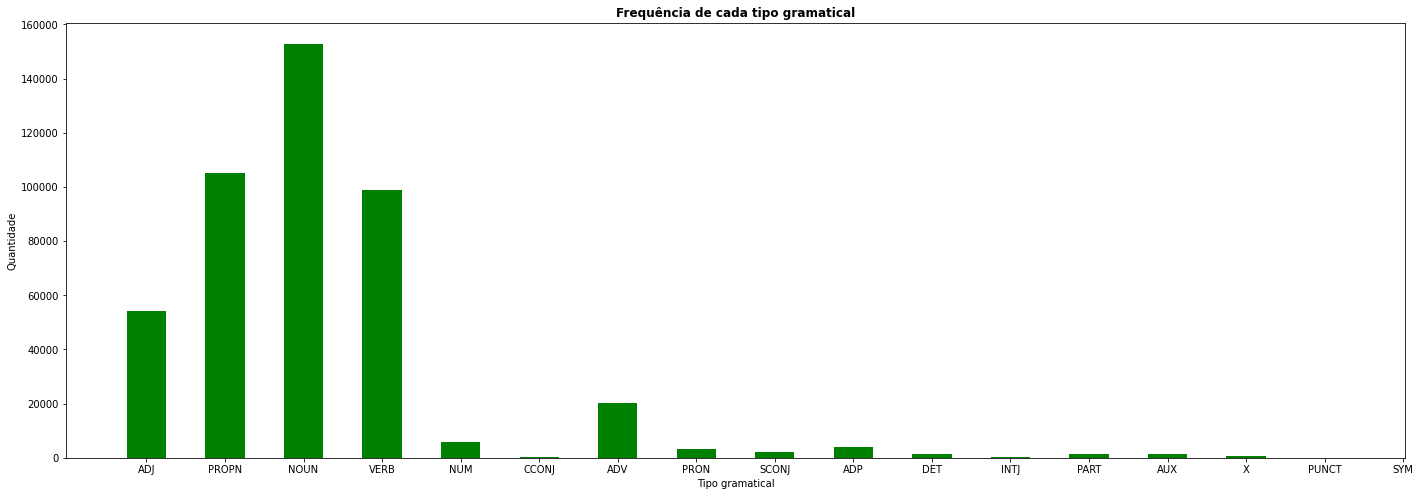

In [ ]:
plt.figure(figsize=(24,8))
plt.hist(token_pos, bins=16, rwidth=0.5, align='left', color='green')

plt.xlabel('Tipo gramatical')
plt.ylabel('Quantidade')
  
plt.title('Frequência de cada tipo gramatical',
          fontweight ="bold")
  
plt.show()

In [ ]:
entities_person_gpe = []
persons = {}
entities_to_search = ['PERSON', 'GPE']

for phrase in processed_description_list:
    doc = nlp(phrase)

    for entity in doc.ents:
      entity_persons_in_doc = []

    if entity.label_ in entities_to_search:
      entities_person_gpe.append((entity.text, entity.label_))
      
      if entity.label_ == 'PERSON':
          entity_persons_in_doc.append(entity.text)
      
      unique_persons = list(set(entity_persons_in_doc))
      
      for unique_person in unique_persons:
        if unique_person in persons.keys():
          persons[unique_person] += 1
        else:
          persons[unique_person] = 1

In [ ]:
entities_person_gpe[:20]

[('hollywood', 'GPE'),
 ('astrakhan maurice', 'PERSON'),
 ('las vegas', 'GPE'),
 ('eve', 'PERSON'),
 ('herbert marshall', 'PERSON'),
 ('kenny doug', 'PERSON'),
 ('theatre company', 'PERSON'),
 ('standup comedy favorite', 'PERSON'),
 ('sleepy joe', 'PERSON'),
 ('mum struggles', 'PERSON'),
 ('irene falls young ronald', 'PERSON'),
 ('kim', 'PERSON'),
 ('hollywood', 'GPE'),
 ('standup', 'PERSON'),
 ('john michael', 'PERSON'),
 ('monte cristo', 'PERSON'),
 ('susan', 'PERSON'),
 ('sicilia', 'GPE'),
 ('sicilia', 'GPE'),
 ('joe', 'PERSON')]

In [ ]:
get_entity = list([ent[1] for ent in entities_person_gpe])

[(entity, get_entity.count(entity)) for entity in set(get_entity)]

[('GPE', 833), ('PERSON', 2719)]

In [ ]:
most_frequent_persons = [(key, value) for key, value in persons.items()]
most_frequent_persons.sort(key= lambda person : person[1], reverse=True)
most_frequent_persons[:10]

[('joe', 14),
 ('david', 11),
 ('tom', 11),
 ('sam', 9),
 ('jane', 9),
 ('steve', 9),
 ('thomas', 8),
 ('dick', 8),
 ('maria', 8),
 ('sarah', 8)]

## Questão 4
Estude o tutorial *Character-level recurrent sequence-to-sequence model* disponível em https://keras.io/examples/nlp/lstm_seq2seq/.

a) Treine um outro modelo de tradução entre línguas distintas e exiba 5 exemplos de tradução de frases curtas. Você pode encontrar conjuntos de treinamento em http://www.manythings.org/anki/.

b) BONUS: Adapte o código para realizar tradução com uma rede *word-level*.


**Referências**